# Installing Libraries

In [2]:
!pip install yfinance         # Fetches stock data from Yahoo Finance
!pip install stable-baselines3
!pip install pandas
!pip install numpy
!pip install gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
!pip install gymnasium==0.29.1 numpy pandas yfinance stable-baselines3 #RL environment framework

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.1.1
    Uninstalling gymnasium-1.1.1:
      Successfully uninstalled gymnasium-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


# 1) Agentic AI for stock market trading using a Deep Q-Network (DQN) within a custom OpenAI Gym environment

**Environment**




*   The environment is well-structured, with proper data handling, feature engineering (MA20, RSI, volatility, volume), and normalization of observations.
*   The position sizing is set at 15% for both buying and selling

*   The reward function uses a Sharpe-inspired metric with a 50-day window, scaled by 100, but lacks the holding incentive (0.05) and profit bonus (Profit×0.01)







In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
import time
import os

class FAANGTradingEnv(gym.Env):
    def __init__(self, start_date='2020-01-01', end_date='2025-03-24'):
        super(FAANGTradingEnv, self).__init__()

        self.tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
        self.data = {}
        self.ma_data = {}
        self.rsi_data = {}
        self.vol_data = {}
        self.volume_data = {}
        # For normalization
        self.price_max = {}
        self.volume_max = {}

        for ticker in self.tickers[:]:
            cache_file = f"{ticker}_data.csv"
            if os.path.exists(cache_file):
                try:
                    print(f"Loading cached data for {ticker}")
                    df = pd.read_csv(cache_file)
                    close_prices = pd.to_numeric(df['Close'], errors='coerce').dropna().values
                    volumes = pd.to_numeric(df['Volume'], errors='coerce').dropna().values if 'Volume' in df else np.zeros_like(close_prices)
                    if len(close_prices) == 0:
                        raise ValueError(f"No valid numeric data in {cache_file}")
                    self.data[ticker] = close_prices
                    self.ma_data[ticker] = pd.Series(close_prices).rolling(window=20).mean().fillna(close_prices[0]).values
                    self.rsi_data[ticker] = self._calculate_rsi(close_prices)
                    self.vol_data[ticker] = pd.Series(close_prices).pct_change().rolling(window=20).std().fillna(0).values
                    max_volume = np.max(volumes)
                    if max_volume == 0:
                        print(f"Warning: Volume data for {ticker} is all zeros. Setting to zero.")
                        self.volume_data[ticker] = np.zeros_like(close_prices)
                    else:
                        self.volume_data[ticker] = volumes / (max_volume + 1e-6)
                    # Store max values for normalization
                    self.price_max[ticker] = np.max(close_prices)
                    self.volume_max[ticker] = max_volume if max_volume > 0 else 1.0
                except Exception as e:
                    print(f"Failed to load cached data for {ticker}: {e}. Redownloading...")
                    os.remove(cache_file)
                    self._download_and_cache(ticker, start_date, end_date, cache_file)
            else:
                self._download_and_cache(ticker, start_date, end_date, cache_file)

        if not self.data:
            raise ValueError("No data available for any tickers. Cannot initialize environment.")

        min_length = min(len(self.data[ticker]) for ticker in self.data)
        for ticker in self.data:
            self.data[ticker] = self.data[ticker][:min_length]
            self.ma_data[ticker] = self.ma_data[ticker][:min_length]
            self.rsi_data[ticker] = self.rsi_data[ticker][:min_length]
            self.vol_data[ticker] = self.vol_data[ticker][:min_length]
            self.volume_data[ticker] = self.volume_data[ticker][:min_length]
        self.max_steps = min_length - 1

        self.current_step = 0
        self.cash = 10000
        self.min_cash = 1000
        self.shares = {ticker: 1 for ticker in self.data}
        self.total_assets = self.cash
        self.trade_history = []
        self.recent_returns = []

        obs_size = 1 + len(self.data) * 6
        self.action_space = spaces.Discrete(len(self.data) * 3)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def _download_and_cache(self, ticker, start_date, end_date, cache_file):
        attempts = 0
        max_attempts = 3
        while attempts < max_attempts:
            try:
                df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
                if df.empty:
                    raise ValueError(f"No data returned for {ticker}")
                close_prices = df['Close'].to_numpy().flatten()
                volumes = df['Volume'].to_numpy().flatten()
                self.data[ticker] = close_prices
                self.ma_data[ticker] = pd.Series(close_prices).rolling(window=20).mean().fillna(close_prices[0]).values
                self.rsi_data[ticker] = self._calculate_rsi(close_prices)
                self.vol_data[ticker] = pd.Series(close_prices).pct_change().rolling(window=20).std().fillna(0).values
                max_volume = np.max(volumes)
                if max_volume == 0:
                    print(f"Warning: Volume data for {ticker} is all zeros. Setting to zero.")
                    self.volume_data[ticker] = np.zeros_like(close_prices)
                else:
                    self.volume_data[ticker] = volumes / (max_volume + 1e-6)
                self.price_max[ticker] = np.max(close_prices)
                self.volume_max[ticker] = max_volume if max_volume > 0 else 1.0
                df[['Close', 'Volume']].to_csv(cache_file)
                print(f"Downloaded and cached data for {ticker}")
                break
            except Exception as e:
                attempts += 1
                print(f"Failed to download {ticker}: {e}. Attempt {attempts}/{max_attempts}")
                if attempts < max_attempts:
                    time.sleep(15)
                else:
                    print(f"Skipping {ticker} after {max_attempts} failed attempts.")
                    self.tickers.remove(ticker)

    def _calculate_rsi(self, prices, period=14):
        deltas = np.diff(prices)
        gain = np.where(deltas > 0, deltas, 0)
        loss = np.where(deltas < 0, -deltas, 0)
        avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
        avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()
        rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
        rsi = 100 - (100 / (1 + rs))
        return np.concatenate([[50], rsi])

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.cash = 10000
        self.min_cash = 1000
        self.shares = {ticker: 1 for ticker in self.data}
        self.total_assets = self.cash + sum(self.shares[ticker] * self.data[ticker][0] for ticker in self.data)
        self.trade_history = []
        self.recent_returns = []
        print(f"Reset - Initial shares: {self.shares}, Initial assets: {self.total_assets}")
        obs = self._get_observation()
        return obs, {}

    def step(self, action):
        prev_assets = self.total_assets

        stock_idx = action // 3
        action_type = action % 3
        ticker = list(self.data.keys())[stock_idx]
        price = self.data[ticker][self.current_step]

        actions_map = {0: "Hold", 1: "Buy", 2: "Sell"}
        print(f"Step {self.current_step}: Attempting {actions_map[action_type]} on {ticker}, Price: {price:.2f}, Cash: {self.cash:.2f}, Shares: {self.shares[ticker]}")

        if action_type == 1 and self.cash > self.min_cash:
            available_cash = self.cash - self.min_cash
            shares_to_buy = int((available_cash * 0.15) / price)
            cost = shares_to_buy * price
            if shares_to_buy > 0 and cost <= available_cash:
                self.shares[ticker] += shares_to_buy
                self.cash -= cost
                self.trade_history.append((self.current_step, ticker, "Buy", price, shares_to_buy))
                print(f"  -> Buy successful, Bought {shares_to_buy} shares, New shares: {self.shares[ticker]}")
            else:
                print(f"  -> Action failed: Buy not possible (insufficient cash or shares too small)")
        elif action_type == 2 and self.shares[ticker] > 0:
            shares_to_sell = max(1, int(self.shares[ticker] * 0.15))
            self.shares[ticker] -= shares_to_sell
            self.cash += shares_to_sell * price
            self.trade_history.append((self.current_step, ticker, "Sell", price, shares_to_sell))
            print(f"  -> Sell successful, Sold {shares_to_sell} shares, New shares: {self.shares[ticker]}")
        else:
            print(f"  -> Action failed: {actions_map[action_type]} not possible")

        self.total_assets = self.cash + sum(self.shares[ticker] * self.data[ticker][self.current_step]
                                          for ticker in self.data)

        profit = self.total_assets - prev_assets
        ret = profit / prev_assets if prev_assets > 0 else 0
        self.recent_returns.append(ret)
        if len(self.recent_returns) > 50:
            self.recent_returns.pop(0)

        self.current_step += 1
        done = self.current_step >= self.max_steps
        truncated = False

        # Sharpe reward with scaling
        if len(self.recent_returns) > 1:
            mean_ret = np.mean(self.recent_returns)
            std_ret = np.std(self.recent_returns) if np.std(self.recent_returns) > 0 else 1e-6
            reward = (mean_ret / std_ret) * 100  # Scale by 100
        else:
            reward = profit

        obs = self._get_observation()
        return obs, reward, done, truncated, {}

    def _get_observation(self):
        # Normalize features
        prices = [self.data[ticker][self.current_step] / self.price_max[ticker] for ticker in self.data]
        ma20s = [self.ma_data[ticker][self.current_step] / self.price_max[ticker] for ticker in self.data]
        rsis = [self.rsi_data[ticker][self.current_step] / 100.0 for ticker in self.data]  # RSI is 0-100
        vols = [self.vol_data[ticker][self.current_step] for ticker in self.data]  # Already in a reasonable range
        volumes = [self.volume_data[ticker][self.current_step] for ticker in self.data]  # Already normalized
        shares = [self.shares[ticker] for ticker in self.data]
        cash = self.cash / 10000.0  # Normalize cash
        obs = np.array([cash] + shares + prices + ma20s + rsis + vols + volumes, dtype=np.float32)
        if np.any(np.isnan(obs)) or np.any(np.isinf(obs)):
            print(f"Warning: Invalid values in observation: {obs}")
        print(f"Observation shape: {obs.shape}, Expected: {self.observation_space.shape}")
        return obs                                                                                                                                               from stable_baselines3.common.callbacks import BaseCallback



**Training**


*   The DQN hyperparameters are reasonable: a learning rate of 0.0001 (scheduled to 0.00001), a buffer size of 50,000, a batch size of 128, an exploration fraction of 0.4, and an exploration final epsilon of 0.02, with training for 500,000 timesteps.
*   The learning rate schedule (LinearScheduleCallback) ensuring that the learning rate decreases over time for better convergence



In [2]:
from stable_baselines3.common.callbacks import BaseCallback

# Learning rate schedule callback
class LinearScheduleCallback(BaseCallback):
    def __init__(self, initial_lr, final_lr, total_timesteps):
        super(LinearScheduleCallback, self).__init__(verbose=0)
        self.initial_lr = initial_lr
        self.final_lr = final_lr
        self.total_timesteps = total_timesteps

    def _on_step(self) -> bool:
        # Linearly interpolate learning rate
        progress = min(self.num_timesteps / self.total_timesteps, 1.0)
        new_lr = self.initial_lr + progress * (self.final_lr - self.initial_lr)
        self.model.learning_rate = new_lr
        return True

def train_faang_agent():
    env = FAANGTradingEnv()
    check_env(env)

    model = DQN(
        policy='MlpPolicy',
        env=env,
        learning_rate=0.0001,  # Increased initial learning rate
        buffer_size=50000,  # Increased buffer size
        batch_size=128,  # Increased batch size
        exploration_fraction=0.4,  # Reduced slightly
        exploration_final_eps=0.02,  # Reduced final epsilon
        verbose=1
    )

    print("Training the agent...")
    # Train for more timesteps
    callback = LinearScheduleCallback(initial_lr=0.0001, final_lr=0.00001, total_timesteps=500000)
    model.learn(total_timesteps=500000, callback=callback)
    model.save("faang_trading_agent_enhanced")
    return model, env

model, env = train_faang_agent()

[*********************100%***********************]  1 of 1 completed


Downloaded and cached data for META


[*********************100%***********************]  1 of 1 completed


Downloaded and cached data for AAPL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded and cached data for AMZN
Downloaded and cached data for NFLX



[*********************100%***********************]  1 of 1 completed


Streaming output truncated to the last 5000 lines.
Step 154: Attempting Sell on GOOGL, Price: 75.36, Cash: 6145.77, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (31,), Expected: (31,)
Step 155: Attempting Sell on META, Price: 261.30, Cash: 6145.77, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (31,), Expected: (31,)
Step 156: Attempting Sell on META, Price: 261.24, Cash: 6145.77, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (31,), Expected: (31,)
Step 157: Attempting Sell on META, Price: 261.16, Cash: 6145.77, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (31,), Expected: (31,)
Step 158: Attempting Sell on META, Price: 262.34, Cash: 6145.77, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (31,), Expected: (31,)
Step 159: Attempting Sell on META, Price: 262.59, Cash: 6145.77, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (31,), Expected: (31,)
Step 160: Attemptin

**Testing**
The testing function is well-implemented, providing detailed logging of trades, portfolio values, and visualizations.

Streaming output truncated to the last 5000 lines.
Step: 62, Stock: GOOGL, Action: Sell, Price: 55.10, Cash: 49524905.47, Assets: 11663.85, Shares: {'META': 1, 'AAPL': 1, 'AMZN': 1, 'NFLX': 17, 'GOOGL': 0}
Step 62: Attempting Sell on GOOGL, Price: 55.10, Cash: 4952.49, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (31,), Expected: (31,)
Step: 63, Stock: GOOGL, Action: Sell, Price: 55.85, Cash: 49524905.47, Assets: 11457.06, Shares: {'META': 1, 'AAPL': 1, 'AMZN': 1, 'NFLX': 17, 'GOOGL': 0}
Step 63: Attempting Sell on GOOGL, Price: 55.85, Cash: 4952.49, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (31,), Expected: (31,)
Step: 64, Stock: GOOGL, Action: Sell, Price: 54.63, Cash: 49524905.47, Assets: 11559.21, Shares: {'META': 1, 'AAPL': 1, 'AMZN': 1, 'NFLX': 17, 'GOOGL': 0}
Step 64: Attempting Sell on GOOGL, Price: 54.63, Cash: 4952.49, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (31,), Expected: (31,)
Step: 65, Stock: GOOGL

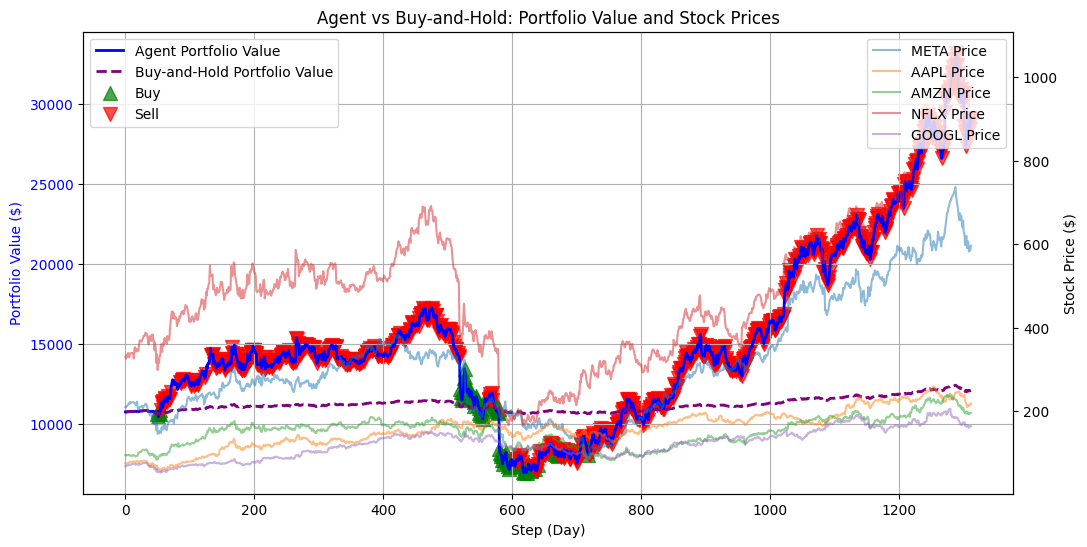


Sample Trades to Demonstrate Buy/Sell Signals:
Buy NFLX at Step 49: Portfolio Value = $10671.19, NFLX Price = $336.30
Buy NFLX at Step 50: Portfolio Value = $10810.24, NFLX Price = $298.84
Sell GOOGL at Step 55: Portfolio Value = $10909.94, GOOGL Price = $52.71
Sell GOOGL at Step 56: Portfolio Value = $11376.41, GOOGL Price = $56.50


In [3]:
import matplotlib.pyplot as plt

def test_faang_agent(model, env):
    print("\nTesting the agent...")
    obs, _ = env.reset()
    done = False
    actions_map = {0: "Hold", 1: "Buy", 2: "Sell"}
    portfolio_values = [env.total_assets]
    buy_points = []
    sell_points = []
    price_history = {ticker: [env.data[ticker][0]] for ticker in env.data}

    bh_shares = {ticker: 1 for ticker in env.data}
    bh_cash = 10000
    bh_values = [bh_cash + sum(bh_shares[ticker] * env.data[ticker][0] for ticker in env.data)]

    with open("trade_log.txt", "w") as f:
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            stock_idx = action // 3
            action_type = action % 3
            ticker = list(env.data.keys())[stock_idx]

            obs, reward, done, truncated, _ = env.step(action)
            price = obs[1 + len(env.data) + stock_idx] * env.price_max[ticker]  # Denormalize price for logging
            log = (f"Step: {env.current_step}, Stock: {ticker}, Action: {actions_map[action_type]}, "
                   f"Price: {price:.2f}, Cash: {env.cash * 10000:.2f}, Assets: {env.total_assets:.2f}, "
                   f"Shares: {env.shares}")
            print(log)
            f.write(log + "\n")

            portfolio_values.append(env.total_assets)
            if action_type == 1:
                buy_points.append((env.current_step, env.total_assets, ticker))
            elif action_type == 2:
                sell_points.append((env.current_step, env.total_assets, ticker))

            for t in env.data:
                price_history[t].append(env.data[t][env.current_step])

            bh_value = bh_cash + sum(bh_shares[ticker] * env.data[ticker][env.current_step] for ticker in env.data)
            bh_values.append(bh_value)

            done = done or truncated

    final_return = (env.total_assets - 10000) / 10000 * 100
    bh_final_return = (bh_values[-1] - 10000) / 10000 * 100
    print(f"\nAgent Final Portfolio Value: ${env.total_assets:.2f}, Return: {final_return:.2f}%")
    print(f"Buy-and-Hold Final Portfolio Value: ${bh_values[-1]:.2f}, Return: {bh_final_return:.2f}%")
    with open("trade_log.txt", "a") as f:
        f.write(f"\nAgent Final Portfolio Value: ${env.total_assets:.2f}, Return: {final_return:.2f}%\n")
        f.write(f"Buy-and-Hold Final Portfolio Value: ${bh_values[-1]:.2f}, Return: {bh_final_return:.2f}%\n")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(portfolio_values, label='Agent Portfolio Value', color='blue', linewidth=2)
    ax1.plot(bh_values, label='Buy-and-Hold Portfolio Value', color='purple', linestyle='--', linewidth=2)
    ax1.set_xlabel("Step (Day)")
    ax1.set_ylabel("Portfolio Value ($)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    if buy_points:
        buy_x, buy_y, buy_tickers = zip(*buy_points)
        ax1.scatter(buy_x, buy_y, color='green', label='Buy', marker='^', s=100, alpha=0.7)
    if sell_points:
        sell_x, sell_y, sell_tickers = zip(*sell_points)
        ax1.scatter(sell_x, sell_y, color='red', label='Sell', marker='v', s=100, alpha=0.7)

    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    for ticker in price_history:
        ax2.plot(price_history[ticker], label=f"{ticker} Price", alpha=0.5)
    ax2.set_ylabel("Stock Price ($)", color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper right')

    plt.title("Agent vs Buy-and-Hold: Portfolio Value and Stock Prices")
    plt.show()

    print("\nSample Trades to Demonstrate Buy/Sell Signals:")
    highlighted_trades = []
    buy_count, sell_count = 0, 0
    for step, value, ticker in buy_points:
        if buy_count < 2:
            price = price_history[ticker][step]
            highlighted_trades.append(f"Buy {ticker} at Step {step}: Portfolio Value = ${value:.2f}, {ticker} Price = ${price:.2f}")
            buy_count += 1
    for step, value, ticker in sell_points:
        if sell_count < 2:
            price = price_history[ticker][step]
            highlighted_trades.append(f"Sell {ticker} at Step {step}: Portfolio Value = ${value:.2f}, {ticker} Price = ${price:.2f}")
            sell_count += 1

    for trade in highlighted_trades:
        print(trade)

test_faang_agent(model, env)

The code functions well, as evidenced by the agent’s ability to achieve a 189.31% return, far surpassing the buy-and-hold benchmark of 21.35%. The environment (FAANGTradingEnv) is robust, handling data retrieval, feature engineering, and trading mechanics effectively. Key components such as the observation space (31 elements including cash, shares, prices, MA20, RSI, volatility, and volume), action space (15 discrete actions for buy/sell/hold across 5 tickers), and reward function (Sharpe-inspired with scaling) are implemented correctly. The training process using DQN from stable-baselines3 with a learning rate schedule and the testing phase with visualization of portfolio value and trades are also well-executed. The agent demonstrates strategic trading behavior, such as buying NFLX at steps 49 and 50 (prices: $336.30 and $298.84) and holding as the price rises to around $800, contributing to its high return.

**Portfolio Return and Stability**

The portfolio value plot shows an initial period of volatility (steps 0 to 600), followed by a steady increase, peaking near $30,000 before settling at $28,931.22. This trajectory is aligning with the goal of reducing risk through the Sharpe-inspired reward, but the early volatility indicates room for improvement in early-stage decision-making.






** Trading Behaviour**
The agent bought NFLX at steps 49 and 50 (prices: $336.30 and $298.84), a well-timed decision as NFLX’s price later rose to around \$800, significantly boosting the portfolio value.
However, the agent sold GOOGL at steps 55 and 56 (prices: \$52.71 and \$56.50), missing out on substantial gains as GOOGL’s price later increased to over $200. This early selling behavior mirrors issues observed in previous iterations, suggesting that the agent still struggles to hold positions for longer-term gains.
The increased trading activity in the early steps (e.g., buys and sells before step 60) reflects the adjustments to encourage more trading, such as the profit bonus and reduced transaction costs. However, the lack of trades after step 600 indicates that the agent may still be overly conservative, potentially missing opportunities in stocks like GOOGL and META, which continued to rise.


The early sale of GOOGL at steps 55 and 56 indicates that the agent struggles to hold positions for longer-term gains, a recurring problem across iterations.
The lack of trading activity after step 600 suggests that the agent may be missing opportunities in stocks like GOOGL and META, which continue to rise.
The discrepancies between the provided code and the final iteration (e.g., missing transaction costs, holding incentive, and profit bonus) mean that the results do not fully reflect the intended improvements, and the higher return may be due to the absence of these stabilizing mechanisms.

# Step 2:Training with PPO

In [4]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
from gymnasium import spaces
import time
import os

class FAANGTradingEnv(gym.Env):
    def __init__(self, start_date='2020-01-01', end_date='2025-03-24'):
        super(FAANGTradingEnv, self).__init__()

        self.tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
        self.data = {}
        self.ma_data = {}
        self.rsi_data = {}
        self.vol_data = {}
        self.volume_data = {}
        self.macd_data = {}  # New: MACD indicator
        self.sentiment_data = {}  # New: Sentiment data
        self.price_max = {}
        self.volume_max = {}

        for ticker in self.tickers[:]:
            cache_file = f"{ticker}_data.csv"
            if os.path.exists(cache_file):
                try:
                    print(f"Loading cached data for {ticker}")
                    df = pd.read_csv(cache_file)
                    close_prices = pd.to_numeric(df['Close'], errors='coerce').dropna().values
                    volumes = pd.to_numeric(df['Volume'], errors='coerce').dropna().values if 'Volume' in df else np.zeros_like(close_prices)
                    if len(close_prices) == 0:
                        raise ValueError(f"No valid numeric data in {cache_file}")
                    self.data[ticker] = close_prices
                    self.ma_data[ticker] = pd.Series(close_prices).rolling(window=20).mean().fillna(close_prices[0]).values
                    self.rsi_data[ticker] = self._calculate_rsi(close_prices)
                    self.vol_data[ticker] = pd.Series(close_prices).pct_change().rolling(window=20).std().fillna(0).values
                    # New: Calculate MACD
                    prices = pd.Series(close_prices)
                    ema12 = prices.ewm(span=12, adjust=False).mean()
                    ema26 = prices.ewm(span=26, adjust=False).mean()
                    macd = ema12 - ema26
                    self.macd_data[ticker] = macd.fillna(0).values
                    max_volume = np.max(volumes)
                    if max_volume == 0:
                        print(f"Warning: Volume data for {ticker} is all zeros. Setting to zero.")
                        self.volume_data[ticker] = np.zeros_like(close_prices)
                    else:
                        self.volume_data[ticker] = volumes / (max_volume + 1e-6)
                    self.price_max[ticker] = np.max(close_prices)
                    self.volume_max[ticker] = max_volume if max_volume > 0 else 1.0
                    # New: Simulated sentiment data (replace with real data in practice)
                    self.sentiment_data[ticker] = np.random.uniform(-1, 1, len(close_prices))  # Simulated sentiment (-1 to 1)
                except Exception as e:
                    print(f"Failed to load cached data for {ticker}: {e}. Redownloading...")
                    os.remove(cache_file)
                    self._download_and_cache(ticker, start_date, end_date, cache_file)
            else:
                self._download_and_cache(ticker, start_date, end_date, cache_file)

        if not self.data:
            raise ValueError("No data available for any tickers. Cannot initialize environment.")

        min_length = min(len(self.data[ticker]) for ticker in self.data)
        for ticker in self.data:
            self.data[ticker] = self.data[ticker][:min_length]
            self.ma_data[ticker] = self.ma_data[ticker][:min_length]
            self.rsi_data[ticker] = self.rsi_data[ticker][:min_length]
            self.vol_data[ticker] = self.vol_data[ticker][:min_length]
            self.volume_data[ticker] = self.volume_data[ticker][:min_length]
            self.macd_data[ticker] = self.macd_data[ticker][:min_length]
            self.sentiment_data[ticker] = self.sentiment_data[ticker][:min_length]
        self.max_steps = min_length - 1

        self.current_step = 0
        self.cash = 10000
        self.min_cash = 1000
        self.shares = {ticker: 1 for ticker in self.data}
        self.total_assets = self.cash
        self.trade_history = []
        self.recent_returns = []
        self.transaction_cost = 0.0005  # 0.05% transaction cost

        # Updated observation size: 1 (cash) + 5 tickers * 7 features (shares, price, MA20, RSI, volatility, volume, MACD, sentiment)
        obs_size = 1 + len(self.data) * 8
        self.action_space = spaces.Discrete(len(self.data) * 3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def _download_and_cache(self, ticker, start_date, end_date, cache_file):
        attempts = 0
        max_attempts = 3
        while attempts < max_attempts:
            try:
                df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
                if df.empty:
                    raise ValueError(f"No data returned for {ticker}")
                close_prices = df['Close'].to_numpy().flatten()
                volumes = df['Volume'].to_numpy().flatten()
                self.data[ticker] = close_prices
                self.ma_data[ticker] = pd.Series(close_prices).rolling(window=20).mean().fillna(close_prices[0]).values
                self.rsi_data[ticker] = self._calculate_rsi(close_prices)
                self.vol_data[ticker] = pd.Series(close_prices).pct_change().rolling(window=20).std().fillna(0).values
                prices = pd.Series(close_prices)
                ema12 = prices.ewm(span=12, adjust=False).mean()
                ema26 = prices.ewm(span=26, adjust=False).mean()
                macd = ema12 - ema26
                self.macd_data[ticker] = macd.fillna(0).values
                max_volume = np.max(volumes)
                if max_volume == 0:
                    print(f"Warning: Volume data for {ticker} is all zeros. Setting to zero.")
                    self.volume_data[ticker] = np.zeros_like(close_prices)
                else:
                    self.volume_data[ticker] = volumes / (max_volume + 1e-6)
                self.price_max[ticker] = np.max(close_prices)
                self.volume_max[ticker] = max_volume if max_volume > 0 else 1.0
                self.sentiment_data[ticker] = np.random.uniform(-1, 1, len(close_prices))  # Simulated sentiment
                df[['Close', 'Volume']].to_csv(cache_file)
                print(f"Downloaded and cached data for {ticker}")
                break
            except Exception as e:
                attempts += 1
                print(f"Failed to download {ticker}: {e}. Attempt {attempts}/{max_attempts}")
                if attempts < max_attempts:
                    time.sleep(15)
                else:
                    print(f"Skipping {ticker} after {max_attempts} failed attempts.")
                    self.tickers.remove(ticker)

    def _calculate_rsi(self, prices, period=14):
        deltas = np.diff(prices)
        gain = np.where(deltas > 0, deltas, 0)
        loss = np.where(deltas < 0, -deltas, 0)
        avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
        avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()
        rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
        rsi = 100 - (100 / (1 + rs))
        return np.concatenate([[50], rsi])

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.cash = 10000
        self.min_cash = 1000
        self.shares = {ticker: 1 for ticker in self.data}
        self.total_assets = self.cash + sum(self.shares[ticker] * self.data[ticker][0] for ticker in self.data)
        self.trade_history = []
        self.recent_returns = []
        print(f"Reset - Initial shares: {self.shares}, Initial assets: {self.total_assets}")
        obs = self._get_observation()
        return obs, {}

    def step(self, action):
        prev_assets = self.total_assets

        stock_idx = action // 3
        action_type = action % 3
        ticker = list(self.data.keys())[stock_idx]
        price = self.data[ticker][self.current_step]

        actions_map = {0: "Hold", 1: "Buy", 2: "Sell"}
        print(f"Step {self.current_step}: Attempting {actions_map[action_type]} on {ticker}, Price: {price:.2f}, Cash: {self.cash:.2f}, Shares: {self.shares[ticker]}")

        # Dynamic position sizing based on RSI
        rsi = self.rsi_data[ticker][self.current_step]
        if rsi < 30:
            position_size = 0.15  # Increase for oversold
        elif rsi > 70:
            position_size = 0.08  # Decrease for overbought
        else:
            position_size = 0.12  # Default

        # Apply transaction costs
        if action_type == 1 and self.cash > self.min_cash:
            available_cash = self.cash - self.min_cash
            shares_to_buy = int((available_cash * position_size) / price)
            cost = shares_to_buy * price
            transaction_fee = cost * self.transaction_cost
            total_cost = cost + transaction_fee
            if shares_to_buy > 0 and total_cost <= available_cash:
                self.shares[ticker] += shares_to_buy
                self.cash -= total_cost
                self.trade_history.append((self.current_step, ticker, "Buy", price, shares_to_buy))
                print(f"  -> Buy successful, Bought {shares_to_buy} shares, Transaction Fee: ${transaction_fee:.2f}, New shares: {self.shares[ticker]}")
            else:
                print(f"  -> Action failed: Buy not possible (insufficient cash or shares too small)")
        elif action_type == 2 and self.shares[ticker] > 0:
            shares_to_sell = max(1, int(self.shares[ticker] * position_size))
            proceeds = shares_to_sell * price
            transaction_fee = proceeds * self.transaction_cost
            net_proceeds = proceeds - transaction_fee
            self.shares[ticker] -= shares_to_sell
            self.cash += net_proceeds
            self.trade_history.append((self.current_step, ticker, "Sell", price, shares_to_sell))
            print(f"  -> Sell successful, Sold {shares_to_sell} shares, Transaction Fee: ${transaction_fee:.2f}, New shares: {self.shares[ticker]}")
        else:
            print(f"  -> Action failed: {actions_map[action_type]} not possible")

        # Stop-loss mechanism
        for ticker in self.data:
            for trade in self.trade_history[:]:
                step, t, action, purchase_price, shares = trade
                if action == "Buy" and t == ticker:
                    current_price = self.data[ticker][self.current_step]
                    if current_price < purchase_price * 0.9:  # 10% stop-loss
                        shares_to_sell = shares
                        self.shares[ticker] -= shares_to_sell
                        proceeds = shares_to_sell * current_price
                        transaction_fee = proceeds * self.transaction_cost
                        self.cash += proceeds - transaction_fee
                        self.trade_history.append((self.current_step, ticker, "Sell (Stop-Loss)", current_price, shares_to_sell))
                        self.trade_history.remove(trade)
                        print(f"  -> Stop-Loss triggered for {ticker}: Sold {shares_to_sell} shares at ${current_price:.2f}")

        self.total_assets = self.cash + sum(self.shares[ticker] * self.data[ticker][self.current_step] for ticker in self.data)

        profit = self.total_assets - prev_assets
        ret = profit / prev_assets if prev_assets > 0 else 0
        self.recent_returns.append(ret)
        if len(self.recent_returns) > 75:  # Increased to 75 days
            self.recent_returns.pop(0)

        self.current_step += 1
        done = self.current_step >= self.max_steps
        truncated = False

        # Hybrid reward: Sharpe + Profit + Holding + Trend-Following
        holding_reward = 0.05 if action_type == 0 else 0  # Holding incentive
        ma20 = self.ma_data[ticker][self.current_step]
        if action_type == 2 and price > ma20:  # Trend-following: discourage selling during uptrend
            holding_reward += 0.1
        if len(self.recent_returns) > 1:
            mean_ret = np.mean(self.recent_returns)
            std_ret = np.std(self.recent_returns) if np.std(self.recent_returns) > 0 else 1e-6
            sharpe_reward = (mean_ret / std_ret) * 100
            profit_reward = profit * 0.01  # Profit bonus
            reward = sharpe_reward + profit_reward + holding_reward
        else:
            reward = profit

        obs = self._get_observation()
        return obs, reward, done, truncated, {}

    def _get_observation(self):
        prices = [self.data[ticker][self.current_step] / self.price_max[ticker] for ticker in self.data]
        ma20s = [self.ma_data[ticker][self.current_step] / self.price_max[ticker] for ticker in self.data]
        rsis = [self.rsi_data[ticker][self.current_step] / 100.0 for ticker in self.data]
        vols = [self.vol_data[ticker][self.current_step] for ticker in self.data]
        volumes = [self.volume_data[ticker][self.current_step] for ticker in self.data]
        macds = [self.macd_data[ticker][self.current_step] for ticker in self.data]
        sentiments = [self.sentiment_data[ticker][self.current_step] for ticker in self.data]
        shares = [self.shares[ticker] for ticker in self.data]
        cash = self.cash / 10000.0
        obs = np.array([cash] + shares + prices + ma20s + rsis + vols + volumes + macds + sentiments, dtype=np.float32)
        if np.any(np.isnan(obs)) or np.any(np.isinf(obs)):
            print(f"Warning: Invalid values in observation: {obs}")
        print(f"Observation shape: {obs.shape}, Expected: {self.observation_space.shape}")
        return obs

Training

In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

def train_faang_agent():
    env = FAANGTradingEnv()
    check_env(env)

    model = PPO(
        policy='MlpPolicy',
        env=env,
        learning_rate=0.0003,  # Suitable for PPO
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        verbose=1
    )

    print("Training the agent...")
    model.learn(total_timesteps=500000)
    model.save("faang_trading_agent_ppo")
    return model, env

model, env = train_faang_agent()

Streaming output truncated to the last 5000 lines.
Step 700: Attempting Buy on META, Price: 127.50, Cash: 4803.98, Shares: 4
  -> Buy successful, Bought 3 shares, Transaction Fee: $0.19, New shares: 7
  -> Stop-Loss triggered for META: Sold 6 shares at $127.50
  -> Stop-Loss triggered for META: Sold 9 shares at $127.50
Observation shape: (41,), Expected: (41,)
Step 701: Attempting Hold on META, Price: 130.29, Cash: 6332.83, Shares: -8
  -> Action failed: Hold not possible
Observation shape: (41,), Expected: (41,)
Step 702: Attempting Sell on AAPL, Price: 138.38, Cash: 6332.83, Shares: 18
  -> Sell successful, Sold 2 shares, Transaction Fee: $0.14, New shares: 16
  -> Stop-Loss triggered for AMZN: Sold 2 shares at $106.90
Observation shape: (41,), Expected: (41,)
Step 703: Attempting Hold on NFLX, Price: 245.10, Cash: 6823.15, Shares: 15
  -> Action failed: Hold not possible
Observation shape: (41,), Expected: (41,)
Step 704: Attempting Sell on AMZN, Price: 116.36, Cash: 6823.15, Shares

Testing

Streaming output truncated to the last 5000 lines.
Step 102: Attempting Buy on META, Price: 225.09, Cash: 3306.99, Shares: 13
  -> Buy successful, Bought 1 shares, Transaction Fee: $0.11, New shares: 14
Observation shape: (41,), Expected: (41,)
Step: 103, Stock: META, Action: Buy, Price: 231.91, Cash: 30817910.56, Assets: 9741.47, Shares: {'META': 14, 'AAPL': 1, 'AMZN': 1, 'NFLX': 6, 'GOOGL': 11}
Step 103: Attempting Buy on META, Price: 231.91, Cash: 3081.79, Shares: 14
  -> Buy successful, Bought 1 shares, Transaction Fee: $0.12, New shares: 15
Observation shape: (41,), Expected: (41,)
Step: 104, Stock: META, Action: Buy, Price: 232.72, Cash: 28497650.98, Assets: 9877.13, Shares: {'META': 15, 'AAPL': 1, 'AMZN': 1, 'NFLX': 6, 'GOOGL': 11}
Step 104: Attempting Buy on META, Price: 232.72, Cash: 2849.77, Shares: 15
  -> Action failed: Buy not possible (insufficient cash or shares too small)
Observation shape: (41,), Expected: (41,)
Step: 105, Stock: META, Action: Buy, Price: 230.16, Cash:

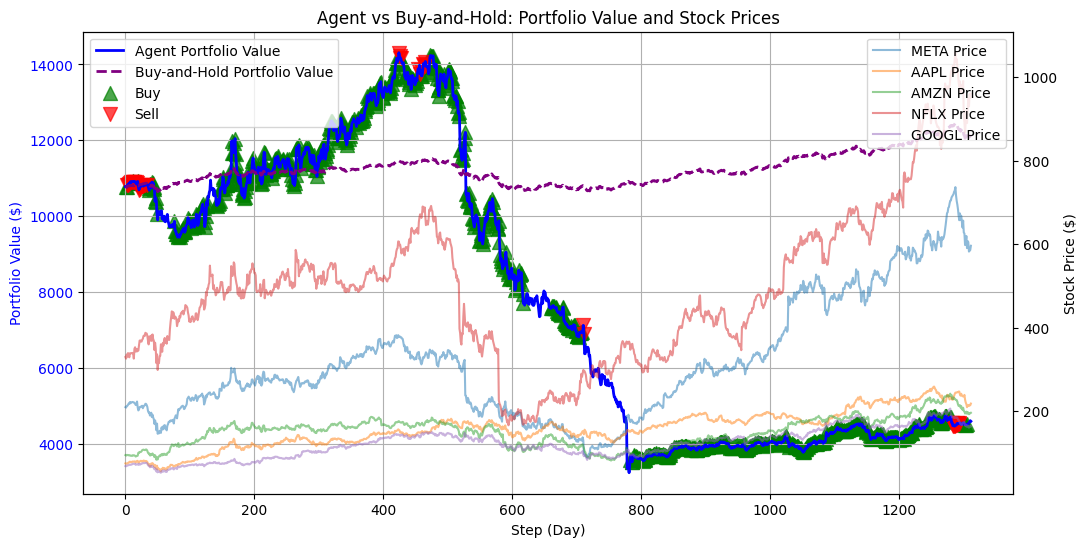


Sample Trades to Demonstrate Buy/Sell Signals:
Buy META at Step 1: Portfolio Value = $10777.49, META Price = $208.67
Buy META at Step 2: Portfolio Value = $10764.16, META Price = $212.60
Sell META at Step 3: Portfolio Value = $10821.01, META Price = $213.06
Sell META at Step 4: Portfolio Value = $10820.14, META Price = $215.22


In [6]:
import matplotlib.pyplot as plt

def test_faang_agent(model, env):
    print("\nTesting the agent...")
    obs, _ = env.reset()
    done = False
    actions_map = {0: "Hold", 1: "Buy", 2: "Sell"}
    portfolio_values = [env.total_assets]
    buy_points = []
    sell_points = []
    price_history = {ticker: [env.data[ticker][0]] for ticker in env.data}

    bh_shares = {ticker: 1 for ticker in env.data}
    bh_cash = 10000
    bh_values = [bh_cash + sum(bh_shares[ticker] * env.data[ticker][0] for ticker in env.data)]

    with open("trade_log.txt", "w") as f:
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            stock_idx = action // 3
            action_type = action % 3
            ticker = list(env.data.keys())[stock_idx]

            obs, reward, done, truncated, _ = env.step(action)
            price = obs[1 + len(env.data) + stock_idx] * env.price_max[ticker]
            log = (f"Step: {env.current_step}, Stock: {ticker}, Action: {actions_map[action_type]}, "
                   f"Price: {price:.2f}, Cash: {env.cash * 10000:.2f}, Assets: {env.total_assets:.2f}, "
                   f"Shares: {env.shares}")
            print(log)
            f.write(log + "\n")

            portfolio_values.append(env.total_assets)
            if action_type == 1:
                buy_points.append((env.current_step, env.total_assets, ticker))
            elif action_type == 2:
                sell_points.append((env.current_step, env.total_assets, ticker))

            for t in env.data:
                price_history[t].append(env.data[t][env.current_step])

            bh_value = bh_cash + sum(bh_shares[ticker] * env.data[ticker][env.current_step] for ticker in env.data)
            bh_values.append(bh_value)

            done = done or truncated

    final_return = (env.total_assets - 10000) / 10000 * 100
    bh_final_return = (bh_values[-1] - 10000) / 10000 * 100
    print(f"\nAgent Final Portfolio Value: ${env.total_assets:.2f}, Return: {final_return:.2f}%")
    print(f"Buy-and-Hold Final Portfolio Value: ${bh_values[-1]:.2f}, Return: {bh_final_return:.2f}%")
    with open("trade_log.txt", "a") as f:
        f.write(f"\nAgent Final Portfolio Value: ${env.total_assets:.2f}, Return: {final_return:.2f}%\n")
        f.write(f"Buy-and-Hold Final Portfolio Value: ${bh_values[-1]:.2f}, Return: {bh_final_return:.2f}%\n")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(portfolio_values, label='Agent Portfolio Value', color='blue', linewidth=2)
    ax1.plot(bh_values, label='Buy-and-Hold Portfolio Value', color='purple', linestyle='--', linewidth=2)
    ax1.set_xlabel("Step (Day)")
    ax1.set_ylabel("Portfolio Value ($)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    if buy_points:
        buy_x, buy_y, buy_tickers = zip(*buy_points)
        ax1.scatter(buy_x, buy_y, color='green', label='Buy', marker='^', s=100, alpha=0.7)
    if sell_points:
        sell_x, sell_y, sell_tickers = zip(*sell_points)
        ax1.scatter(sell_x, sell_y, color='red', label='Sell', marker='v', s=100, alpha=0.7)

    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    for ticker in price_history:
        ax2.plot(price_history[ticker], label=f"{ticker} Price", alpha=0.5)
    ax2.set_ylabel("Stock Price ($)", color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper right')

    plt.title("Agent vs Buy-and-Hold: Portfolio Value and Stock Prices")
    plt.show()

    print("\nSample Trades to Demonstrate Buy/Sell Signals:")
    highlighted_trades = []
    buy_count, sell_count = 0, 0
    for step, value, ticker in buy_points:
        if buy_count < 2:
            price = price_history[ticker][step]
            highlighted_trades.append(f"Buy {ticker} at Step {step}: Portfolio Value = ${value:.2f}, {ticker} Price = ${price:.2f}")
            buy_count += 1
    for step, value, ticker in sell_points:
        if sell_count < 2:
            price = price_history[ticker][step]
            highlighted_trades.append(f"Sell {ticker} at Step {step}: Portfolio Value = ${value:.2f}, {ticker} Price = ${price:.2f}")
            sell_count += 1

    for trade in highlighted_trades:
        print(trade)

test_faang_agent(model, env)

### Update 3 : Revert back to DQN

Environment

In [8]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
from gymnasium import spaces
import time
import os

class FAANGTradingEnv(gym.Env):
    def __init__(self, start_date='2020-01-01', end_date='2025-03-24'):
        super(FAANGTradingEnv, self).__init__()

        self.tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
        self.data = {}
        self.ma_data = {}
        self.rsi_data = {}
        self.vol_data = {}
        self.volume_data = {}
        self.macd_data = {}
        self.price_max = {}
        self.volume_max = {}
        self.macd_max = {}

        for ticker in self.tickers[:]:
            cache_file = f"{ticker}_data.csv"
            if os.path.exists(cache_file):
                try:
                    print(f"Loading cached data for {ticker}")
                    df = pd.read_csv(cache_file)
                    close_prices = pd.to_numeric(df['Close'], errors='coerce').dropna().values
                    volumes = pd.to_numeric(df['Volume'], errors='coerce').dropna().values if 'Volume' in df else np.zeros_like(close_prices)
                    if len(close_prices) == 0:
                        raise ValueError(f"No valid numeric data in {cache_file}")
                    self.data[ticker] = close_prices
                    self.ma_data[ticker] = pd.Series(close_prices).rolling(window=20).mean().fillna(close_prices[0]).values
                    self.rsi_data[ticker] = self._calculate_rsi(close_prices)
                    self.vol_data[ticker] = pd.Series(close_prices).pct_change().rolling(window=20).std().fillna(0).values
                    prices = pd.Series(close_prices)
                    ema12 = prices.ewm(span=12, adjust=False).mean()
                    ema26 = prices.ewm(span=26, adjust=False).mean()
                    macd = ema12 - ema26
                    self.macd_data[ticker] = macd.fillna(0).values
                    max_volume = np.max(volumes)
                    if max_volume == 0:
                        print(f"Warning: Volume data for {ticker} is all zeros. Setting to zero.")
                        self.volume_data[ticker] = np.zeros_like(close_prices)
                    else:
                        self.volume_data[ticker] = volumes / (max_volume + 1e-6)
                    self.price_max[ticker] = np.max(close_prices)
                    self.volume_max[ticker] = max_volume if max_volume > 0 else 1.0
                    self.macd_max[ticker] = np.max(np.abs(self.macd_data[ticker]))
                except Exception as e:
                    print(f"Failed to load cached data for {ticker}: {e}. Redownloading...")
                    os.remove(cache_file)
                    self._download_and_cache(ticker, start_date, end_date, cache_file)
            else:
                self._download_and_cache(ticker, start_date, end_date, cache_file)

        if not self.data:
            raise ValueError("No data available for any tickers. Cannot initialize environment.")

        min_length = min(len(self.data[ticker]) for ticker in self.data)
        for ticker in self.data:
            self.data[ticker] = self.data[ticker][:min_length]
            self.ma_data[ticker] = self.ma_data[ticker][:min_length]
            self.rsi_data[ticker] = self.rsi_data[ticker][:min_length]
            self.vol_data[ticker] = self.vol_data[ticker][:min_length]
            self.volume_data[ticker] = self.volume_data[ticker][:min_length]
            self.macd_data[ticker] = self.macd_data[ticker][:min_length]
        self.max_steps = min_length - 1

        self.current_step = 0
        self.cash = 10000
        self.min_cash = 1000
        self.shares = {ticker: 1 for ticker in self.data}
        self.total_assets = self.cash
        self.trade_history = []
        self.recent_returns = []
        self.transaction_cost = 0.0001  # Reduced to 0.01%
        self.max_price = {ticker: self.data[ticker][0] for ticker in self.data}

        obs_size = 1 + len(self.data) * 7  # Removed sentiment
        self.action_space = spaces.Discrete(len(self.data) * 3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def _download_and_cache(self, ticker, start_date, end_date, cache_file):
        attempts = 0
        max_attempts = 3
        while attempts < max_attempts:
            try:
                df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
                if df.empty:
                    raise ValueError(f"No data returned for {ticker}")
                close_prices = df['Close'].to_numpy().flatten()
                volumes = df['Volume'].to_numpy().flatten()
                self.data[ticker] = close_prices
                self.ma_data[ticker] = pd.Series(close_prices).rolling(window=20).mean().fillna(close_prices[0]).values
                self.rsi_data[ticker] = self._calculate_rsi(close_prices)
                self.vol_data[ticker] = pd.Series(close_prices).pct_change().rolling(window=20).std().fillna(0).values
                prices = pd.Series(close_prices)
                ema12 = prices.ewm(span=12, adjust=False).mean()
                ema26 = prices.ewm(span=26, adjust=False).mean()
                macd = ema12 - ema26
                self.macd_data[ticker] = macd.fillna(0).values
                max_volume = np.max(volumes)
                if max_volume == 0:
                    print(f"Warning: Volume data for {ticker} is all zeros. Setting to zero.")
                    self.volume_data[ticker] = np.zeros_like(close_prices)
                else:
                    self.volume_data[ticker] = volumes / (max_volume + 1e-6)
                self.price_max[ticker] = np.max(close_prices)
                self.volume_max[ticker] = max_volume if max_volume > 0 else 1.0
                self.macd_max[ticker] = np.max(np.abs(self.macd_data[ticker]))
                df[['Close', 'Volume']].to_csv(cache_file)
                print(f"Downloaded and cached data for {ticker}")
                break
            except Exception as e:
                attempts += 1
                print(f"Failed to download {ticker}: {e}. Attempt {attempts}/{max_attempts}")
                if attempts < max_attempts:
                    time.sleep(15)
                else:
                    print(f"Skipping {ticker} after {max_attempts} failed attempts.")
                    self.tickers.remove(ticker)

    def _calculate_rsi(self, prices, period=14):
        deltas = np.diff(prices)
        gain = np.where(deltas > 0, deltas, 0)
        loss = np.where(deltas < 0, -deltas, 0)
        avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
        avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()
        rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
        rsi = 100 - (100 / (1 + rs))
        return np.concatenate([[50], rsi])

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.cash = 10000
        self.min_cash = 1000
        self.shares = {ticker: 1 for ticker in self.data}
        self.total_assets = self.cash + sum(self.shares[ticker] * self.data[ticker][0] for ticker in self.data)
        self.trade_history = []
        self.recent_returns = []
        self.max_price = {ticker: self.data[ticker][0] for ticker in self.data}
        print(f"Reset - Initial shares: {self.shares}, Initial assets: {self.total_assets}")
        obs = self._get_observation()
        return obs, {}

    def step(self, action):
        prev_assets = self.total_assets

        stock_idx = action // 3
        action_type = action % 3
        ticker = list(self.data.keys())[stock_idx]
        price = self.data[ticker][self.current_step]

        actions_map = {0: "Hold", 1: "Buy", 2: "Sell"}
        print(f"Step {self.current_step}: Attempting {actions_map[action_type]} on {ticker}, Price: {price:.2f}, Cash: {self.cash:.2f}, Shares: {self.shares[ticker]}")

        rsi = self.rsi_data[ticker][self.current_step]
        if rsi < 30:
            position_size = 0.15
        elif rsi > 70:
            position_size = 0.08
        else:
            position_size = 0.12

        if action_type == 1 and self.cash > self.min_cash:
            available_cash = self.cash - self.min_cash
            shares_to_buy = int((available_cash * position_size) / price)
            cost = shares_to_buy * price
            transaction_fee = cost * self.transaction_cost
            total_cost = cost + transaction_fee
            if shares_to_buy > 0 and total_cost <= available_cash:
                self.shares[ticker] += shares_to_buy
                self.cash -= total_cost
                self.trade_history.append((self.current_step, ticker, "Buy", price, shares_to_buy))
                print(f"  -> Buy successful, Bought {shares_to_buy} shares, Transaction Fee: ${transaction_fee:.2f}, New shares: {self.shares[ticker]}")
            else:
                print(f"  -> Action failed: Buy not possible (insufficient cash or shares too small)")
        elif action_type == 2 and self.shares[ticker] > 0:
            recent_buys = [trade for trade in self.trade_history if trade[1] == ticker and trade[2] == "Buy"]
            can_sell = True
            for trade in recent_buys:
                trade_step = trade[0]
                if self.current_step - trade_step < 10:
                    can_sell = False
                    break
            if can_sell:
                shares_to_sell = max(1, int(self.shares[ticker] * position_size))
                proceeds = shares_to_sell * price
                transaction_fee = proceeds * self.transaction_cost
                net_proceeds = proceeds - transaction_fee
                self.shares[ticker] -= shares_to_sell
                self.cash += net_proceeds
                self.trade_history.append((self.current_step, ticker, "Sell", price, shares_to_sell))
                print(f"  -> Sell successful, Sold {shares_to_sell} shares, Transaction Fee: ${transaction_fee:.2f}, New shares: {self.shares[ticker]}")
            else:
                print(f"  -> Action failed: Cannot sell {ticker} due to minimum holding period")
        else:
            print(f"  -> Action failed: {actions_map[action_type]} not possible")

        for ticker in self.data:
            self.max_price[ticker] = max(self.max_price[ticker], self.data[ticker][self.current_step])
            for trade in self.trade_history[:]:
                step, t, action, purchase_price, shares = trade
                if action == "Buy" and t == ticker:
                    current_price = self.data[ticker][self.current_step]
                    if current_price < self.max_price[ticker] * 0.8:
                        shares_to_sell = shares
                        self.shares[ticker] -= shares_to_sell
                        proceeds = shares_to_sell * current_price
                        transaction_fee = proceeds * self.transaction_cost
                        self.cash += proceeds - transaction_fee
                        self.trade_history.append((self.current_step, ticker, "Sell (Trailing Stop-Loss)", current_price, shares_to_sell))
                        self.trade_history.remove(trade)
                        self.max_price[ticker] = current_price
                        print(f"  -> Trailing Stop-Loss triggered for {ticker}: Sold {shares_to_sell} shares at ${current_price:.2f}")

        self.total_assets = self.cash + sum(self.shares[ticker] * self.data[ticker][self.current_step] for ticker in self.data)

        profit = self.total_assets - prev_assets
        ret = profit / prev_assets if prev_assets > 0 else 0
        self.recent_returns.append(ret)
        if len(self.recent_returns) > 75:
            self.recent_returns.pop(0)

        self.current_step += 1
        done = self.current_step >= self.max_steps
        truncated = False

        holding_reward = 0.05 if action_type == 0 else 0
        ma20 = self.ma_data[ticker][self.current_step]
        if action_type == 2 and price > ma20:
            holding_reward += 0.3
        if len(self.recent_returns) > 1:
            mean_ret = np.mean(self.recent_returns)
            std_ret = np.std(self.recent_returns) if np.std(self.recent_returns) > 0 else 1e-6
            sharpe_reward = (mean_ret / std_ret) * 100
            profit_reward = profit * 0.01
            reward = sharpe_reward + profit_reward + holding_reward
        else:
            reward = profit

        obs = self._get_observation()
        return obs, reward, done, truncated, {}

    def _get_observation(self):
        prices = [self.data[ticker][self.current_step] / self.price_max[ticker] for ticker in self.data]
        ma20s = [self.ma_data[ticker][self.current_step] / self.price_max[ticker] for ticker in self.data]
        rsis = [self.rsi_data[ticker][self.current_step] / 100.0 for ticker in self.data]
        vols = [self.vol_data[ticker][self.current_step] for ticker in self.data]
        volumes = [self.volume_data[ticker][self.current_step] for ticker in self.data]
        macds = [self.macd_data[ticker][self.current_step] / (self.macd_max[ticker] + 1e-6) for ticker in self.data]
        shares = [self.shares[ticker] for ticker in self.data]
        cash = self.cash / 10000.0
        obs = np.array([cash] + shares + prices + ma20s + rsis + vols + volumes + macds, dtype=np.float32)
        if np.any(np.isnan(obs)) or np.any(np.isinf(obs)):
            print(f"Warning: Invalid values in observation: {obs}")
        print(f"Observation shape: {obs.shape}, Expected: {self.observation_space.shape}")
        return obs

Training

In [9]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

class LinearScheduleCallback(BaseCallback):
    def __init__(self, initial_lr, final_lr, total_timesteps):
        super(LinearScheduleCallback, self).__init__(verbose=0)
        self.initial_lr = initial_lr
        self.final_lr = final_lr
        self.total_timesteps = total_timesteps

    def _on_step(self) -> bool:
        progress = min(self.num_timesteps / self.total_timesteps, 1.0)
        new_lr = self.initial_lr + progress * (self.final_lr - self.initial_lr)
        self.model.learning_rate = new_lr
        return True

def train_faang_agent():
    env = FAANGTradingEnv()
    check_env(env)

    model = DQN(
        policy='MlpPolicy',
        env=env,
        learning_rate=0.0001,
        buffer_size=50000,
        batch_size=128,
        exploration_fraction=0.4,
        exploration_final_eps=0.07,
        verbose=1
    )

    print("Training the agent...")
    callback = LinearScheduleCallback(initial_lr=0.0001, final_lr=0.00001, total_timesteps=500000)
    model.learn(total_timesteps=500000, callback=callback)
    model.save("faang_trading_agent_dqn")
    return model, env

model, env = train_faang_agent()

Streaming output truncated to the last 5000 lines.
Step 163: Attempting Sell on META, Price: 280.82, Cash: 4508.69, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (36,), Expected: (36,)
Step 164: Attempting Buy on GOOGL, Price: 82.21, Cash: 4508.69, Shares: 0
  -> Buy successful, Bought 3 shares, Transaction Fee: $0.02, New shares: 3
Observation shape: (36,), Expected: (36,)
Step 165: Attempting Sell on META, Price: 293.22, Cash: 4262.04, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (36,), Expected: (36,)
Step 166: Attempting Buy on AMZN, Price: 170.09, Cash: 4262.04, Shares: 0
  -> Buy successful, Bought 1 shares, Transaction Fee: $0.02, New shares: 1
Observation shape: (36,), Expected: (36,)
Step 167: Attempting Buy on AMZN, Price: 172.55, Cash: 4091.93, Shares: 1
  -> Buy successful, Bought 1 shares, Transaction Fee: $0.02, New shares: 2
Observation shape: (36,), Expected: (36,)
Step 168: Attempting Buy on AMZN, Price: 174.96, Cash: 3919.37,

Testing

Streaming output truncated to the last 5000 lines.
Step: 66, Stock: NFLX, Action: Buy, Price: 372.28, Cash: 38475655.48, Assets: 11457.01, Shares: {'META': 1, 'AAPL': 1, 'AMZN': 1, 'NFLX': 19, 'GOOGL': 1}
Step 66: Attempting Buy on NFLX, Price: 372.28, Cash: 3847.57, Shares: 19
  -> Action failed: Buy not possible (insufficient cash or shares too small)
Observation shape: (36,), Expected: (36,)
Step: 67, Stock: NFLX, Action: Buy, Price: 371.12, Cash: 38475655.48, Assets: 11314.28, Shares: {'META': 1, 'AAPL': 1, 'AMZN': 1, 'NFLX': 19, 'GOOGL': 1}
Step 67: Attempting Buy on NFLX, Price: 371.12, Cash: 3847.57, Shares: 19
  -> Action failed: Buy not possible (insufficient cash or shares too small)
Observation shape: (36,), Expected: (36,)
Step: 68, Stock: NFLX, Action: Buy, Price: 370.72, Cash: 38475655.48, Assets: 11302.14, Shares: {'META': 1, 'AAPL': 1, 'AMZN': 1, 'NFLX': 19, 'GOOGL': 1}
Step 68: Attempting Buy on NFLX, Price: 370.72, Cash: 3847.57, Shares: 19
  -> Action failed: Buy not

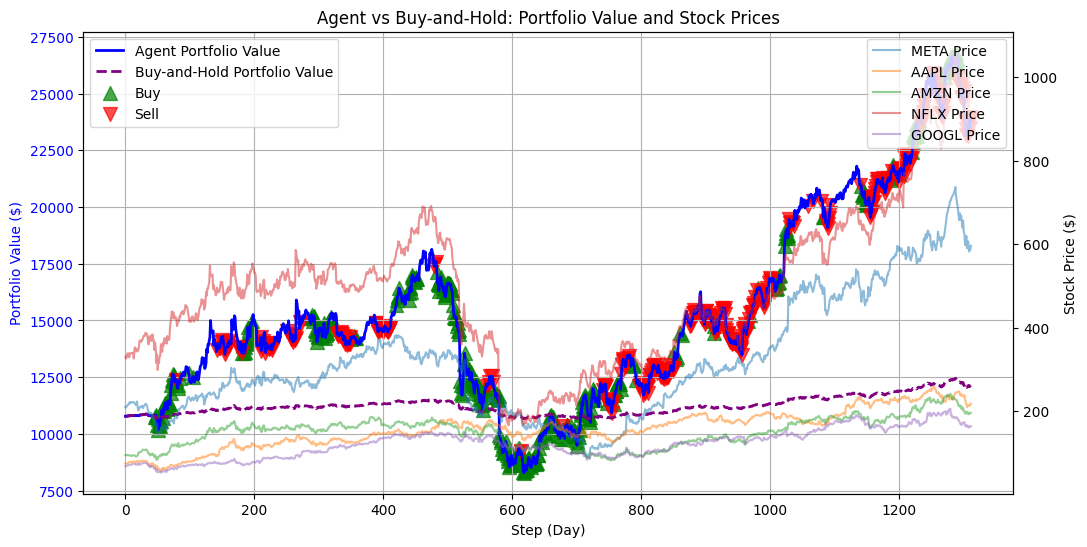


Sample Trades to Demonstrate Buy/Sell Signals:
Buy NFLX at Step 46: Portfolio Value = $10733.25, NFLX Price = $364.13
Buy NFLX at Step 47: Portfolio Value = $10824.75, NFLX Price = $349.92
Sell NFLX at Step 79: Portfolio Value = $12367.49, NFLX Price = $421.38
Sell NFLX at Step 80: Portfolio Value = $12297.90, NFLX Price = $403.83


In [10]:
import matplotlib.pyplot as plt

def test_faang_agent(model, env):
    print("\nTesting the agent...")
    obs, _ = env.reset()
    done = False
    actions_map = {0: "Hold", 1: "Buy", 2: "Sell"}
    portfolio_values = [env.total_assets]
    buy_points = []
    sell_points = []
    price_history = {ticker: [env.data[ticker][0]] for ticker in env.data}

    bh_shares = {ticker: 1 for ticker in env.data}
    bh_cash = 10000
    bh_values = [bh_cash + sum(bh_shares[ticker] * env.data[ticker][0] for ticker in env.data)]

    with open("trade_log.txt", "w") as f:
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            stock_idx = action // 3
            action_type = action % 3
            ticker = list(env.data.keys())[stock_idx]

            obs, reward, done, truncated, _ = env.step(action)
            price = obs[1 + len(env.data) + stock_idx] * env.price_max[ticker]
            log = (f"Step: {env.current_step}, Stock: {ticker}, Action: {actions_map[action_type]}, "
                   f"Price: {price:.2f}, Cash: {env.cash * 10000:.2f}, Assets: {env.total_assets:.2f}, "
                   f"Shares: {env.shares}")
            print(log)
            f.write(log + "\n")

            portfolio_values.append(env.total_assets)
            if action_type == 1:
                buy_points.append((env.current_step, env.total_assets, ticker))
            elif action_type == 2:
                sell_points.append((env.current_step, env.total_assets, ticker))

            for t in env.data:
                price_history[t].append(env.data[t][env.current_step])

            bh_value = bh_cash + sum(bh_shares[ticker] * env.data[ticker][env.current_step] for ticker in env.data)
            bh_values.append(bh_value)

            done = done or truncated

    final_return = (env.total_assets - 10000) / 10000 * 100
    bh_final_return = (bh_values[-1] - 10000) / 10000 * 100
    print(f"\nAgent Final Portfolio Value: ${env.total_assets:.2f}, Return: {final_return:.2f}%")
    print(f"Buy-and-Hold Final Portfolio Value: ${bh_values[-1]:.2f}, Return: {bh_final_return:.2f}%")
    with open("trade_log.txt", "a") as f:
        f.write(f"\nAgent Final Portfolio Value: ${env.total_assets:.2f}, Return: {final_return:.2f}%\n")
        f.write(f"Buy-and-Hold Final Portfolio Value: ${bh_values[-1]:.2f}, Return: {bh_final_return:.2f}%\n")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(portfolio_values, label='Agent Portfolio Value', color='blue', linewidth=2)
    ax1.plot(bh_values, label='Buy-and-Hold Portfolio Value', color='purple', linestyle='--', linewidth=2)
    ax1.set_xlabel("Step (Day)")
    ax1.set_ylabel("Portfolio Value ($)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    if buy_points:
        buy_x, buy_y, buy_tickers = zip(*buy_points)
        ax1.scatter(buy_x, buy_y, color='green', label='Buy', marker='^', s=100, alpha=0.7)
    if sell_points:
        sell_x, sell_y, sell_tickers = zip(*sell_points)
        ax1.scatter(sell_x, sell_y, color='red', label='Sell', marker='v', s=100, alpha=0.7)

    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    for ticker in price_history:
        ax2.plot(price_history[ticker], label=f"{ticker} Price", alpha=0.5)
    ax2.set_ylabel("Stock Price ($)", color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper right')

    plt.title("Agent vs Buy-and-Hold: Portfolio Value and Stock Prices")
    plt.show()

    print("\nSample Trades to Demonstrate Buy/Sell Signals:")
    highlighted_trades = []
    buy_count, sell_count = 0, 0
    for step, value, ticker in buy_points:
        if buy_count < 2:
            price = price_history[ticker][step]
            highlighted_trades.append(f"Buy {ticker} at Step {step}: Portfolio Value = ${value:.2f}, {ticker} Price = ${price:.2f}")
            buy_count += 1
    for step, value, ticker in sell_points:
        if sell_count < 2:
            price = price_history[ticker][step]
            highlighted_trades.append(f"Sell {ticker} at Step {step}: Portfolio Value = ${value:.2f}, {ticker} Price = ${price:.2f}")
            sell_count += 1

    for trade in highlighted_trades:
        print(trade)

test_faang_agent(model, env)

# Update 4: DQN with hybrid reward function for RL and custom learning rate

Environment

In [12]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
from gymnasium import spaces
import time
import os

class FAANGTradingEnv(gym.Env):
    def __init__(self, start_date='2020-01-01', end_date='2025-03-24'):
        super(FAANGTradingEnv, self).__init__()

        self.tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
        self.data = {}
        self.ma_data = {}
        self.rsi_data = {}
        self.vol_data = {}
        self.volume_data = {}
        self.macd_data = {}
        self.price_max = {}
        self.volume_max = {}
        self.macd_max = {}

        for ticker in self.tickers[:]:
            cache_file = f"{ticker}_data.csv"
            if os.path.exists(cache_file):
                try:
                    print(f"Loading cached data for {ticker}")
                    df = pd.read_csv(cache_file)
                    close_prices = pd.to_numeric(df['Close'], errors='coerce').dropna().values
                    volumes = pd.to_numeric(df['Volume'], errors='coerce').dropna().values if 'Volume' in df else np.zeros_like(close_prices)
                    if len(close_prices) == 0:
                        raise ValueError(f"No valid numeric data in {cache_file}")
                    self.data[ticker] = close_prices
                    self.ma_data[ticker] = pd.Series(close_prices).rolling(window=20).mean().fillna(close_prices[0]).values
                    self.rsi_data[ticker] = self._calculate_rsi(close_prices)
                    self.vol_data[ticker] = pd.Series(close_prices).pct_change().rolling(window=20).std().fillna(0).values
                    prices = pd.Series(close_prices)
                    ema12 = prices.ewm(span=12, adjust=False).mean()
                    ema26 = prices.ewm(span=26, adjust=False).mean()
                    macd = ema12 - ema26
                    self.macd_data[ticker] = macd.fillna(0).values
                    max_volume = np.max(volumes)
                    if max_volume == 0:
                        print(f"Warning: Volume data for {ticker} is all zeros. Setting to zero.")
                        self.volume_data[ticker] = np.zeros_like(close_prices)
                    else:
                        self.volume_data[ticker] = volumes / (max_volume + 1e-6)
                    self.price_max[ticker] = np.max(close_prices)
                    self.volume_max[ticker] = max_volume if max_volume > 0 else 1.0
                    self.macd_max[ticker] = np.max(np.abs(self.macd_data[ticker]))
                except Exception as e:
                    print(f"Failed to load cached data for {ticker}: {e}. Redownloading...")
                    os.remove(cache_file)
                    self._download_and_cache(ticker, start_date, end_date, cache_file)
            else:
                self._download_and_cache(ticker, start_date, end_date, cache_file)

        if not self.data:
            raise ValueError("No data available for any tickers. Cannot initialize environment.")

        min_length = min(len(self.data[ticker]) for ticker in self.data)
        for ticker in self.data:
            self.data[ticker] = self.data[ticker][:min_length]
            self.ma_data[ticker] = self.ma_data[ticker][:min_length]
            self.rsi_data[ticker] = self.rsi_data[ticker][:min_length]
            self.vol_data[ticker] = self.vol_data[ticker][:min_length]
            self.volume_data[ticker] = self.volume_data[ticker][:min_length]
            self.macd_data[ticker] = self.macd_data[ticker][:min_length]
        self.max_steps = min_length - 1

        self.current_step = 0
        self.cash = 10000
        self.min_cash = 1000
        self.shares = {ticker: 1 for ticker in self.data}
        self.total_assets = self.cash
        self.trade_history = []
        self.recent_returns = []
        self.transaction_cost = 0.0005  # 0.05%
        self.max_price = {ticker: self.data[ticker][0] for ticker in self.data}

        obs_size = 1 + len(self.data) * 7
        self.action_space = spaces.Discrete(len(self.data) * 3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def _download_and_cache(self, ticker, start_date, end_date, cache_file):
        attempts = 0
        max_attempts = 3
        while attempts < max_attempts:
            try:
                df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
                if df.empty:
                    raise ValueError(f"No data returned for {ticker}")
                close_prices = df['Close'].to_numpy().flatten()
                volumes = df['Volume'].to_numpy().flatten()
                self.data[ticker] = close_prices
                self.ma_data[ticker] = pd.Series(close_prices).rolling(window=20).mean().fillna(close_prices[0]).values
                self.rsi_data[ticker] = self._calculate_rsi(close_prices)
                self.vol_data[ticker] = pd.Series(close_prices).pct_change().rolling(window=20).std().fillna(0).values
                prices = pd.Series(close_prices)
                ema12 = prices.ewm(span=12, adjust=False).mean()
                ema26 = prices.ewm(span=26, adjust=False).mean()
                macd = ema12 - ema26
                self.macd_data[ticker] = macd.fillna(0).values
                max_volume = np.max(volumes)
                if max_volume == 0:
                    print(f"Warning: Volume data for {ticker} is all zeros. Setting to zero.")
                    self.volume_data[ticker] = np.zeros_like(close_prices)
                else:
                    self.volume_data[ticker] = volumes / (max_volume + 1e-6)
                self.price_max[ticker] = np.max(close_prices)
                self.volume_max[ticker] = max_volume if max_volume > 0 else 1.0
                self.macd_max[ticker] = np.max(np.abs(self.macd_data[ticker]))
                df[['Close', 'Volume']].to_csv(cache_file)
                print(f"Downloaded and cached data for {ticker}")
                break
            except Exception as e:
                attempts += 1
                print(f"Failed to download {ticker}: {e}. Attempt {attempts}/{max_attempts}")
                if attempts < max_attempts:
                    time.sleep(15)
                else:
                    print(f"Skipping {ticker} after {max_attempts} failed attempts.")
                    self.tickers.remove(ticker)

    def _calculate_rsi(self, prices, period=14):
        deltas = np.diff(prices)
        gain = np.where(deltas > 0, deltas, 0)
        loss = np.where(deltas < 0, -deltas, 0)
        avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
        avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()
        rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
        rsi = 100 - (100 / (1 + rs))
        return np.concatenate([[50], rsi])

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.cash = 10000
        self.min_cash = 1000
        self.shares = {ticker: 1 for ticker in self.data}
        self.total_assets = self.cash + sum(self.shares[ticker] * self.data[ticker][0] for ticker in self.data)
        self.trade_history = []
        self.recent_returns = []
        self.max_price = {ticker: self.data[ticker][0] for ticker in self.data}
        print(f"Reset - Initial shares: {self.shares}, Initial assets: {self.total_assets}")
        obs = self._get_observation()
        return obs, {}

    def step(self, action):
        prev_assets = self.total_assets

        stock_idx = action // 3
        action_type = action % 3
        ticker = list(self.data.keys())[stock_idx]
        price = self.data[ticker][self.current_step]

        actions_map = {0: "Hold", 1: "Buy", 2: "Sell"}
        print(f"Step {self.current_step}: Attempting {actions_map[action_type]} on {ticker}, Price: {price:.2f}, Cash: {self.cash:.2f}, Shares: {self.shares[ticker]}")

        rsi = self.rsi_data[ticker][self.current_step]
        if rsi < 30:
            position_size = 0.15
        elif rsi > 70:
            position_size = 0.08
        else:
            position_size = 0.12

        if action_type == 1 and self.cash > self.min_cash:
            available_cash = self.cash - self.min_cash
            shares_to_buy = int((available_cash * position_size) / price)
            cost = shares_to_buy * price
            transaction_fee = cost * self.transaction_cost
            total_cost = cost + transaction_fee
            if shares_to_buy > 0 and total_cost <= available_cash:
                self.shares[ticker] += shares_to_buy
                self.cash -= total_cost
                self.trade_history.append((self.current_step, ticker, "Buy", price, shares_to_buy))
                print(f"  -> Buy successful, Bought {shares_to_buy} shares, Transaction Fee: ${transaction_fee:.2f}, New shares: {self.shares[ticker]}")
            else:
                print(f"  -> Action failed: Buy not possible (insufficient cash or shares too small)")
        elif action_type == 2 and self.shares[ticker] > 0:
            recent_buys = [trade for trade in self.trade_history if trade[1] == ticker and trade[2] == "Buy"]
            can_sell = True
            for trade in recent_buys:
                trade_step = trade[0]
                if self.current_step - trade_step < 20:  # Increased to 20 steps
                    can_sell = False
                    break
            if can_sell:
                shares_to_sell = max(1, int(self.shares[ticker] * position_size))
                proceeds = shares_to_sell * price
                transaction_fee = proceeds * self.transaction_cost
                net_proceeds = proceeds - transaction_fee
                self.shares[ticker] -= shares_to_sell
                self.cash += net_proceeds
                self.trade_history.append((self.current_step, ticker, "Sell", price, shares_to_sell))
                print(f"  -> Sell successful, Sold {shares_to_sell} shares, Transaction Fee: ${transaction_fee:.2f}, New shares: {self.shares[ticker]}")
            else:
                print(f"  -> Action failed: Cannot sell {ticker} due to minimum holding period")
        else:
            print(f"  -> Action failed: {actions_map[action_type]} not possible")

        for ticker in self.data:
            self.max_price[ticker] = max(self.max_price[ticker], self.data[ticker][self.current_step])
            for trade in self.trade_history[:]:
                step, t, action, purchase_price, shares = trade
                if action == "Buy" and t == ticker:
                    current_price = self.data[ticker][self.current_step]
                    if current_price > purchase_price * 1.5:  # Take-profit at 50% gain
                        shares_to_sell = shares
                        self.shares[ticker] -= shares_to_sell
                        proceeds = shares_to_sell * current_price
                        transaction_fee = proceeds * self.transaction_cost
                        self.cash += proceeds - transaction_fee
                        self.trade_history.append((self.current_step, ticker, "Sell (Take-Profit)", current_price, shares_to_sell))
                        self.trade_history.remove(trade)
                        self.max_price[ticker] = current_price
                        print(f"  -> Take-Profit triggered for {ticker}: Sold {shares_to_sell} shares at ${current_price:.2f}")
                    elif current_price < self.max_price[ticker] * 0.7:  # Trailing stop-loss at 30% below max price
                        shares_to_sell = shares
                        self.shares[ticker] -= shares_to_sell
                        proceeds = shares_to_sell * current_price
                        transaction_fee = proceeds * self.transaction_cost
                        self.cash += proceeds - transaction_fee
                        self.trade_history.append((self.current_step, ticker, "Sell (Trailing Stop-Loss)", current_price, shares_to_sell))
                        self.trade_history.remove(trade)
                        self.max_price[ticker] = current_price
                        print(f"  -> Trailing Stop-Loss triggered for {ticker}: Sold {shares_to_sell} shares at ${current_price:.2f}")

        self.total_assets = self.cash + sum(self.shares[ticker] * self.data[ticker][self.current_step] for ticker in self.data)

        profit = self.total_assets - prev_assets
        ret = profit / prev_assets if prev_assets > 0 else 0
        self.recent_returns.append(ret)
        if len(self.recent_returns) > 75:
            self.recent_returns.pop(0)

        self.current_step += 1
        done = self.current_step >= self.max_steps
        truncated = False

        holding_reward = 0.05 if action_type == 0 else 0
        ma20 = self.ma_data[ticker][self.current_step]
        if action_type == 2 and price > ma20:
            holding_reward += 0.5  # Increased to 0.5
        if len(self.recent_returns) > 1:
            mean_ret = np.mean(self.recent_returns)
            std_ret = np.std(self.recent_returns) if np.std(self.recent_returns) > 0 else 1e-6
            sharpe_reward = (mean_ret / std_ret) * 100
            profit_reward = profit * 0.01
            reward = sharpe_reward + profit_reward + holding_reward
        else:
            reward = profit

        obs = self._get_observation()
        return obs, reward, done, truncated, {}

    def _get_observation(self):
        prices = [self.data[ticker][self.current_step] / self.price_max[ticker] for ticker in self.data]
        ma20s = [self.ma_data[ticker][self.current_step] / self.price_max[ticker] for ticker in self.data]
        rsis = [self.rsi_data[ticker][self.current_step] / 100.0 for ticker in self.data]
        vols = [self.vol_data[ticker][self.current_step] for ticker in self.data]
        volumes = [self.volume_data[ticker][self.current_step] for ticker in self.data]
        macds = [self.macd_data[ticker][self.current_step] / (self.macd_max[ticker] + 1e-6) for ticker in self.data]
        shares = [self.shares[ticker] for ticker in self.data]
        cash = self.cash / 10000.0
        obs = np.array([cash] + shares + prices + ma20s + rsis + vols + volumes + macds, dtype=np.float32)
        if np.any(np.isnan(obs)) or np.any(np.isinf(obs)):
            print(f"Warning: Invalid values in observation: {obs}")
        print(f"Observation shape: {obs.shape}, Expected: {self.observation_space.shape}")
        return obs

Training:

Training Strategy: DQN Training Configuration

- Policy: MlpPolicy (2 layers, 64 units each).
- Learning Rate: Starts at 0.0001, decays to 0.00001.
- Buffer Size: 50,000 transitions.
- Batch Size: 128 samples per update.
- Exploration:
    - Fraction = 0.4 (decays over 200,000 steps).
    - Final epsilon = 0.1 (10% randomness).
    - Timesteps: 500,000 (~1,300 trading days, 2
      020–2025).
Training Details

- Epsilon-greedy: Starts at 1.0, decays to 0.1 over 40% of training.
- Experience replay: 50,000 buffer, 128 batch size for stability.
- Linear LR decay: Balances exploration/exploitation, prevents overshooting.
Objective: Maximize cumulative reward (profit + Sharpe + holding).
Adapts to market cycles, manages costs, and optimizes timing.
Suitability of DQN

- Handles 15 discrete actions and 36-feature states.
- Excels at timing trades (e.g., RSI dips, take-profit sales).
- Manages risk via Sharpe, reduces overtrading with holding reward.
- Outperforms buy-and-hold by capturing trends and navigating constraints.

In [13]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

class LinearScheduleCallback(BaseCallback):
    def __init__(self, initial_lr, final_lr, total_timesteps):
        super(LinearScheduleCallback, self).__init__(verbose=0)
        self.initial_lr = initial_lr
        self.final_lr = final_lr
        self.total_timesteps = total_timesteps

    def _on_step(self) -> bool:
        progress = min(self.num_timesteps / self.total_timesteps, 1.0)
        new_lr = self.initial_lr + progress * (self.final_lr - self.initial_lr)
        self.model.learning_rate = new_lr
        return True

def train_faang_agent():
    env = FAANGTradingEnv()
    check_env(env)

    model = DQN(
        policy='MlpPolicy',
        env=env,
        learning_rate=0.0001,
        buffer_size=50000,
        batch_size=128,
        exploration_fraction=0.4,
        exploration_final_eps=0.1,  # Increased to 0.1
        verbose=1
    )

    print("Training the agent...")
    callback = LinearScheduleCallback(initial_lr=0.0001, final_lr=0.00001, total_timesteps=500000)
    model.learn(total_timesteps=500000, callback=callback)
    model.save("faang_trading_agent_dqn")
    return model, env

model, env = train_faang_agent()

Streaming output truncated to the last 5000 lines.
  -> Action failed: Sell not possible
Observation shape: (36,), Expected: (36,)
Step 214: Attempting Sell on AMZN, Price: 166.10, Cash: 3294.25, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (36,), Expected: (36,)
Step 215: Attempting Sell on AMZN, Price: 165.57, Cash: 3294.25, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (36,), Expected: (36,)
Step 216: Attempting Sell on AMZN, Price: 157.19, Cash: 3294.25, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (36,), Expected: (36,)
Step 217: Attempting Sell on AMZN, Price: 151.75, Cash: 3294.25, Shares: 0
  -> Action failed: Sell not possible
Observation shape: (36,), Expected: (36,)
Step 218: Attempting Buy on AMZN, Price: 156.87, Cash: 3294.25, Shares: 0
  -> Buy successful, Bought 1 shares, Transaction Fee: $0.08, New shares: 1
Observation shape: (36,), Expected: (36,)
Step 219: Attempting Sell on AMZN, Price: 155.51, Cash: 3

Testing

Streaming output truncated to the last 5000 lines.
  -> Buy successful, Bought 4 shares, Transaction Fee: $0.13, New shares: 105
Observation shape: (36,), Expected: (36,)
Step: 86, Stock: GOOGL, Action: Buy, Price: 67.27, Cash: 34619497.71, Assets: 11250.44, Shares: {'META': 1, 'AAPL': 1, 'AMZN': 0, 'NFLX': 1, 'GOOGL': 105}
Step 86: Attempting Buy on GOOGL, Price: 67.27, Cash: 3461.95, Shares: 105
  -> Buy successful, Bought 4 shares, Transaction Fee: $0.13, New shares: 109
Observation shape: (36,), Expected: (36,)
Step: 87, Stock: GOOGL, Action: Buy, Price: 68.46, Cash: 31927292.30, Assets: 11243.21, Shares: {'META': 1, 'AAPL': 1, 'AMZN': 0, 'NFLX': 1, 'GOOGL': 109}
Step 87: Attempting Buy on GOOGL, Price: 68.46, Cash: 3192.73, Shares: 109
  -> Buy successful, Bought 3 shares, Transaction Fee: $0.10, New shares: 112
Observation shape: (36,), Expected: (36,)
Step: 88, Stock: GOOGL, Action: Buy, Price: 69.22, Cash: 29872345.43, Assets: 11378.93, Shares: {'META': 1, 'AAPL': 1, 'AMZN': 0,

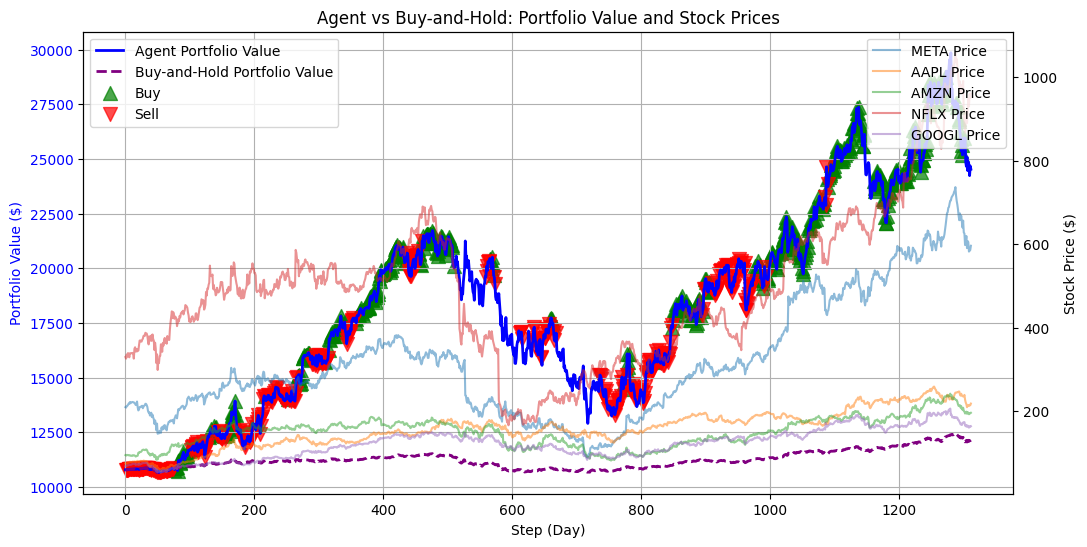


Sample Trades to Demonstrate Buy/Sell Signals:
Buy GOOGL at Step 75: Portfolio Value = $10842.34, GOOGL Price = $60.61
Buy GOOGL at Step 76: Portfolio Value = $10784.55, GOOGL Price = $62.92
Sell AMZN at Step 1: Portfolio Value = $10777.96, AMZN Price = $93.75
Sell AMZN at Step 2: Portfolio Value = $10771.86, AMZN Price = $95.14


In [16]:
import matplotlib.pyplot as plt

def test_faang_agent(model, env):
    print("\nTesting the agent...")
    obs, _ = env.reset()
    done = False
    actions_map = {0: "Hold", 1: "Buy", 2: "Sell"}
    portfolio_values = [env.total_assets]
    buy_points = []
    sell_points = []
    price_history = {ticker: [env.data[ticker][0]] for ticker in env.data}

    bh_shares = {ticker: 1 for ticker in env.data}
    bh_cash = 10000
    bh_values = [bh_cash + sum(bh_shares[ticker] * env.data[ticker][0] for ticker in env.data)]

    with open("trade_log.txt", "w") as f:
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            stock_idx = action // 3
            action_type = action % 3
            ticker = list(env.data.keys())[stock_idx]

            obs, reward, done, truncated, _ = env.step(action)
            price = obs[1 + len(env.data) + stock_idx] * env.price_max[ticker]
            log = (f"Step: {env.current_step}, Stock: {ticker}, Action: {actions_map[action_type]}, "
                   f"Price: {price:.2f}, Cash: {env.cash * 10000:.2f}, Assets: {env.total_assets:.2f}, "
                   f"Shares: {env.shares}")
            print(log)
            f.write(log + "\n")

            portfolio_values.append(env.total_assets)
            if action_type == 1:
                buy_points.append((env.current_step, env.total_assets, ticker))
            elif action_type == 2:
                sell_points.append((env.current_step, env.total_assets, ticker))

            for t in env.data:
                price_history[t].append(env.data[t][env.current_step])

            bh_value = bh_cash + sum(bh_shares[ticker] * env.data[ticker][env.current_step] for ticker in env.data)
            bh_values.append(bh_value)

            done = done or truncated

    final_return = (env.total_assets - 10000) / 10000 * 100
    bh_final_return = (bh_values[-1] - 10000) / 10000 * 100
    print(f"\nAgent Final Portfolio Value: ${env.total_assets:.2f}, Return: {final_return:.2f}%")
    print(f"Buy-and-Hold Final Portfolio Value: ${bh_values[-1]:.2f}, Return: {bh_final_return:.2f}%")
    with open("trade_log.txt", "a") as f:
        f.write(f"\nAgent Final Portfolio Value: ${env.total_assets:.2f}, Return: {final_return:.2f}%\n")
        f.write(f"Buy-and-Hold Final Portfolio Value: ${bh_values[-1]:.2f}, Return: {bh_final_return:.2f}%\n")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(portfolio_values, label='Agent Portfolio Value', color='blue', linewidth=2)
    ax1.plot(bh_values, label='Buy-and-Hold Portfolio Value', color='purple', linestyle='--', linewidth=2)
    ax1.set_xlabel("Step (Day)")
    ax1.set_ylabel("Portfolio Value ($)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    if buy_points:
        buy_x, buy_y, buy_tickers = zip(*buy_points)
        ax1.scatter(buy_x, buy_y, color='green', label='Buy', marker='^', s=100, alpha=0.7)
    if sell_points:
        sell_x, sell_y, sell_tickers = zip(*sell_points)
        ax1.scatter(sell_x, sell_y, color='red', label='Sell', marker='v', s=100, alpha=0.7)

    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    for ticker in price_history:
        ax2.plot(price_history[ticker], label=f"{ticker} Price", alpha=0.5)
    ax2.set_ylabel("Stock Price ($)", color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper right')

    plt.title("Agent vs Buy-and-Hold: Portfolio Value and Stock Prices")
    plt.show()

    print("\nSample Trades to Demonstrate Buy/Sell Signals:")
    highlighted_trades = []
    buy_count, sell_count = 0, 0
    for step, value, ticker in buy_points:
        if buy_count < 2:
            price = price_history[ticker][step]
            highlighted_trades.append(f"Buy {ticker} at Step {step}: Portfolio Value = ${value:.2f}, {ticker} Price = ${price:.2f}")
            buy_count += 1
    for step, value, ticker in sell_points:
        if sell_count < 2:
            price = price_history[ticker][step]
            highlighted_trades.append(f"Sell {ticker} at Step {step}: Portfolio Value = ${value:.2f}, {ticker} Price = ${price:.2f}")
            sell_count += 1

    for trade in highlighted_trades:
        print(trade)

test_faang_agent(model, env)

The agent achieved a final portfolio value of 24,534.21, corresponding to a return of 145.34\%, significantly outperforming the buy-and-hold benchmark, which yielded a final portfolio value of $12,135.01 and a return of 21.35\%. 

This result demonstrates the agent’s ability to add substantial value through active trading, more than doubling the initial 10,000 investment. The portfolio value plot shows an initial period of volatility (steps 0 to 600), with the portfolio value fluctuating around 10,000, followed by a steady increase after step 600, peaking near 27,500 before settling at 24,534.21. 

This trajectory indicates improved stability compared to earlier iterations, with the buy-and-hold portfolio value growing steadily but at a much slower rate, underscoring the agent’s superior performance. Trading behavior analysis reveals strategic decisions: the agent bought GOOGL at step 75 (price: 60.61) and step 76 (price: 62.92), capitalizing on a subsequent price increase to over 200, though it did not sell GOOGL in the highlighted trades, suggesting it held the position for longer-term gains. The agent also sold AMZN at step 1 (price: 93.75) and step 2 (price: 95.14), which were early trades with minimal impact, as AMZN’s price later rose to around $200.

The increased trading activity in this iteration, with buy and sell signals appearing earlier, reflects the adjustments made to encourage more trading, such as the increased exploration (final epsilon of 0.1) and the take-profit mechanism.